## This notebook produces event-level cost-based fragility functions

2018 USD Damage State (DS) thresholds are 10k, 1M, 10M, 100M. The second half of this script repeats the process with additional damage state threshold (1k) and fewer comments. Only US events are used in this calculation, including 12 with liquefaction damage and 41 without liquefaction damage.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
import seaborn as sns
from scipy import stats
import math
from scipy.optimize import minimize, LinearConstraint
import matplotlib.ticker as mtick
import scipy.optimize

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [18]:
spec = 10000 # Number specified as rounded up to nearest log10 integer from max(HaggLQ)
xxx = np.linspace(1,spec, num=spec) # Array of 1 to 10000, as integers
xxx = np.log10(xxx) # Finds logs of above values, should be 1 to 4
xxx2 = np.linspace(0,max(xxx),num=int(max(xxx)*3+1)) # Breaking up into 2 bins per log 10
xxx3=10**xxx2 # Creating actual bin bound values
xxx4 = xxx3.tolist()
xxx4[0] = xxx4[0]-1.01

df = pd.read_csv("gfailruns_allevents_forAlex_v2.3.csv") # Import CSV of Name, TLSE, Building level, Transportation Level, Utilities Level
df = df.dropna(subset=['Buildings_Cost']) # Drop rows where DS is No Value for Buildings (should be same rows for Transportation and Utilities)

In [19]:
pd.set_option('max_columns', None)
pd.set_option("max_rows", None)

In [20]:
df.drop(df[df['American?'] == 0].index, inplace=True) # Dropping non-American events

In [21]:
df["Dam_Code"].value_counts()

1.0    34
4.0    12
2.0     5
3.0     1
5.0     1
Name: Dam_Code, dtype: int64

# Cell below creates and assigns bins for TLSE (Htot)


In [9]:
# Minimum bin edge must be slightly less than 0 to account for TLSE=0
# EDP_cut_bins = np.linspace(-100, 5200, num=54)
EDP_cut_bins = xxx4

#################################################################################
# Create bins of TLSE labels and sort events into Bins
EDP_cut_labels = np.linspace(0,len(EDP_cut_bins)-2,num=int(len(EDP_cut_bins)-1))
# Creating column for which bin the TLSE falls into
df['TLSE_Bin'] = pd.cut(df['HaggLQ'], bins=EDP_cut_bins, labels=EDP_cut_labels)


# Calculating middle value for each bin
zipped_lists = zip(EDP_cut_bins[0:len(EDP_cut_bins)-1], EDP_cut_bins[1:len(EDP_cut_bins)])
Bin_Avg = [(x + y)/2 for (x, y) in zipped_lists]

# Making dataframe in which we can view damage level data
df2 = pd.DataFrame(zip(EDP_cut_bins[0:len(EDP_cut_bins)-1], EDP_cut_bins[1:len(EDP_cut_bins)],
                            Bin_Avg[0:len(EDP_cut_bins)-1], EDP_cut_labels[0:len(EDP_cut_bins)-1]),
                            columns=['Bin_Min', 'Bin_Max','Bin_Avg','Bin_Labels']) 

# Counting number of analyses per bin
def count_(bin_type,bin_lev):
    subset_df = df[bin_type == bin_lev]
    return subset_df.TLSE_Bin.count()

y=[]
# Need to have a +1 because of the way range() counts upwards, it stops 1 short of upper limit
# For all labels, count the number of analyses in that level
for i in range(0,len(EDP_cut_labels)):
    y.append(count_(df.TLSE_Bin,i)) 
    
# Appending this column to dataframe or recreate dataframe with it included
df2['Num_Analyses']=y

df2.drop(df2[df2['Num_Analyses'] == 0].index, inplace=True) # Dropping bins with 0 events
df2 = df2.reset_index(drop=True) # resetting index to start at 0

## Cell below will assign DS to each category and event

In [10]:
# Create bins of damage level labels and sort events into Bins
damage_cut_labels = [0,1,2,3,4]
# Minimum bin edge must be slightly less than 0 to account for dollars damage =0
damage_cut_bins = [-0.1, 10000, 1000000, 10000000, 100000000, 1000000000]
def damagelevel(infrastructure):
    df[str(infrastructure)+'_CostBin'] = pd.cut(df[str(infrastructure)+'_Cost'], bins=damage_cut_bins, labels=damage_cut_labels)
    df.head(20)

damagelevel('Buildings')
damagelevel('Transportation')
damagelevel('Utilities')
damagelevel('Total')

## Cell below continues with frag calc using Cost DSs

In [11]:
# Probably going to change the below line to fit new DSs
d = [df["Buildings_Cost"].max(), df["Transportation_Cost"].max(), df["Utilities_Cost"].min()]
DS_max = len(damage_cut_labels)

# Counts the number of events over a specified damage level for each TLSE bin
def count_(bin_type, T_bin_lev, Dam_bin_lev):
    # select only rows where the TLSE bin is equal to bin i
    subset_df=df[df.TLSE_Bin == T_bin_lev]
    # select only rows where the buildings/transportation/utilities level is >= level j
    subset_df=subset_df[bin_type >= Dam_bin_lev]
    return subset_df.TLSE_Bin.count()

# Appends number exceeding DS to arrays in correct order
# For the range of all damage states, need +1 because of way range counts upwards
for j in range(0,len(damage_cut_labels)):
    # Creating empty arrays 
    y1=[]
    y2=[]
    y3=[]
    y4=[]
    
    # For each EDP Bin
    for i in range(0,len(df2)): 
        # count the number of analyses of damage state "j", for bin label in row "i" of df2
        # Uses the function "count_" created a few blocks up
        y1.append(count_(df.Buildings_CostBin, df2.iloc[i,3], j))        
        y2.append(count_(df.Transportation_CostBin, df2.iloc[i,3], j))
        y3.append(count_(df.Utilities_CostBin, df2.iloc[i,3], j))
        y4.append(count_(df.Total_CostBin, df2.iloc[i,3],j))
    df3 = pd.DataFrame(y1)
    # CDS instead of DS represents "Cost Damage States"
    # "Observed" refers to proportion of total analyses for that bin reaching specified CDS
    df2['Buildings_CDS_'+str(j)] = df3
    df2['Buildings_CDS_'+str(j)+'_Observed'] = df2['Buildings_CDS_'+str(j)]/df2['Num_Analyses']
    df3 = pd.DataFrame(y2)
    df2['Transportation_CDS_'+str(j)] = df3
    df2['Transportation_CDS_'+str(j)+'_Observed'] = df2['Transportation_CDS_'+str(j)]/df2['Num_Analyses']
    df3 = pd.DataFrame(y3)
    df2['Utilities_CDS_'+str(j)] = df3
    df2['Utilities_CDS_'+str(j)+'_Observed'] = df2['Utilities_CDS_'+str(j)]/df2['Num_Analyses']
    df3 = pd.DataFrame(y4)
    df2['Total_CDS_'+str(j)] = df3
    df2['Total_CDS_'+str(j)+'_Observed'] = df2['Total_CDS_'+str(j)]/df2['Num_Analyses']
    
df5 = df2.drop(['Buildings_CDS_0', 'Buildings_CDS_0_Observed', 'Transportation_CDS_0', 
                'Transportation_CDS_0_Observed', 'Utilities_CDS_0', 
                'Utilities_CDS_0_Observed'], axis=1) # Drop these columns

/Users/Alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


## Frag fxns with no fixed lines, no param correc

In [12]:
# df4 represents creating x values of fragility curve itself
# Must start at 1 instead of 0 because log(0) does not exist
xx = np.linspace(1, max(df['HaggLQ']), num=int(max(df['HaggLQ'])))
df4 = pd.DataFrame(xx,columns=['Aggregate Liquefaction Hazard'])
aa = df4.iloc[:,0]

def g_2(category):
    
    # Plotting fragility functions with observed points
    mpl.style.use('default')
    fig, ax = plt.subplots(figsize=(6, 4.5))
    csfont = {'fontname':'Times New Roman'}
    ax.set_xscale('log')
    
    for DS in range(1,len(damage_cut_labels)):
      # This is where we need to have definition of loop start    
        a1 = df2.iloc[:,4] # Num events in each bin
        a2 = df2[str(category)+'_CDS_'+str(DS)] # Num exceedances (Building level 1) in each bin
        a3 = df2.iloc[:,2] # Avg bin TLSE values

        a1 = a1.values.tolist()
        a2 = a2.values.tolist()
        a3 = a3.values.tolist()

        print(a2)
        # Define function to be maximum using Automation
        def f(params):
            theta, beta = params
            bounds = ((0,None),(0,None))
            # CDF finds the probability of exceeding damage state
            # PMF is the likelihood of achieving the CDF value given the number of events in each bin and exceedances of damage state
            # Get product of likelihoods
            # Use -1 to get maximum insted of minimum
            c = []
            d = []
            for i in range(0,len(df2)):
                c.append(stats.binom.pmf(a2[i], a1[i], stats.norm.cdf(math.log(a3[i]), loc=math.log(theta),scale=beta)))  
            return -1*np.product([c])

        # Minimize the defined function using starting theta and beta
        # Some reason this is coming out with parameters near the input only instead of actual results
        #res = minimize(f,[80,1],method='Nelder-Mead',maxiter=None)
        res = minimize(f,[80,1],method='Nelder-Mead', options={'maxiter': 10000})

        if res.success:
            fitted_params = res.x
            print(fitted_params)
        else:
            raise ValueError(res.message)

        # Creating fitted fragility points from fitted parameters for the curve
        yy=[]
        for i in range(0,len(df4)):
            yy.append(stats.norm.cdf(math.log(aa[i]),loc=math.log(fitted_params[0]),scale=fitted_params[1]))
        ######################################################################  
        df4['Fitted_Values_CDS_'+str(DS)]=yy # Adding column to dataframe
        # THE ABOVE ALSO CONTAINS RELATIONSHIPS 
    ######################################################################   

    ax.plot('Aggregate Liquefaction Hazard', 'Fitted_Values_CDS_1', 'k-', label=str(category)+' 1'+' Fitted',data=df4)
    ax.plot('Bin_Avg', str(category)+'_CDS_1'+'_Observed','k+', markersize=16,
            label=str(category)+' 1'+' Observed',data=df5)

    ax.plot('Aggregate Liquefaction Hazard', 'Fitted_Values_CDS_2', 'k--', label=str(category)+' 2'+' Fitted',data=df4)
    ax.plot('Bin_Avg', str(category)+'_CDS_2'+'_Observed','ko', mfc='none', markersize=10,
           label=str(category)+' 2'+' Observed',data=df5) # DS_1 observed
    
    ax.plot('Aggregate Liquefaction Hazard', 'Fitted_Values_CDS_3', 'k-.', label=str(category)+' 3'+' Fitted',data=df4)
    ax.plot('Bin_Avg', str(category)+'_CDS_3'+'_Observed','kx', markersize=10,
            label=str(category)+' 3'+' Observed',data=df5)

    ax.plot('Aggregate Liquefaction Hazard', 'Fitted_Values_CDS_4', 'k:', label=str(category)+' 4'+' Fitted',data=df4)
    ax.plot('Bin_Avg', str(category)+'_CDS_4'+'_Observed','k*', mfc='none', markersize=10,
           label=str(category)+' 4'+' Observed',data=df5) # DS_1 observed

    plt.xlabel('Aggregate Liquefaction Hazard Bin Average', fontsize=10,**csfont)
    plt.ylabel('Probability of Exceeding Damage State Thresholds', fontsize=10,**csfont)
    plt.legend(loc='upper left', fontsize='8')
    
    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.xaxis.set_major_formatter(tick)
    plt.xticks([1,10,100,1000],**csfont)
        # For ticks, need max to be one unit higher than the value I actually want
    plt.ylim(-0.05, 1.05)
    plt.yticks(np.arange(0, 1.2, 0.2),**csfont)
    plt.grid(linestyle='-', linewidth='0.5')
    #plt.savefig('HtotCostFxns_4Levs_'+str(category)+'.png',format="PNG",dpi=500,bbox_inches="tight")

[0, 1, 0, 0, 2, 1, 2, 2, 1, 0]
[218.54740801   2.40198303]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
[539.57558944   2.0659668 ]
[0, 0, 0, 0, 1, 0, 1, 1, 1, 0]
[732.20459887   2.0102117 ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2.81986523e+03 3.63525391e-02]
[0, 1, 0, 0, 2, 1, 2, 2, 1, 1]
[112.35568431   1.76795533]
[0, 0, 0, 0, 1, 1, 2, 1, 1, 1]
[163.78071148   1.1571591 ]
[0, 0, 0, 0, 0, 0, 2, 1, 1, 1]
[208.18477846   0.64952736]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
[873.43487667   1.27015454]
[0, 1, 0, 0, 1, 1, 2, 1, 1, 1]
[211.18102995   2.06770978]
[0, 0, 0, 0, 1, 0, 1, 0, 1, 1]
[451.07992092   1.52324449]
[0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
[395.92230432   0.80055054]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2.81986523e+03 3.63525391e-02]
[0, 1, 0, 0, 2, 1, 2, 2, 1, 1]
[112.35568431   1.76795533]
[0, 1, 0, 0, 1, 1, 2, 2, 1, 1]
[135.25890109   1.74119913]
[0, 0, 0, 0, 1, 0, 2, 2, 1, 1]
[132.38057838   0.79625849]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
[873.43487667   1.27015454]


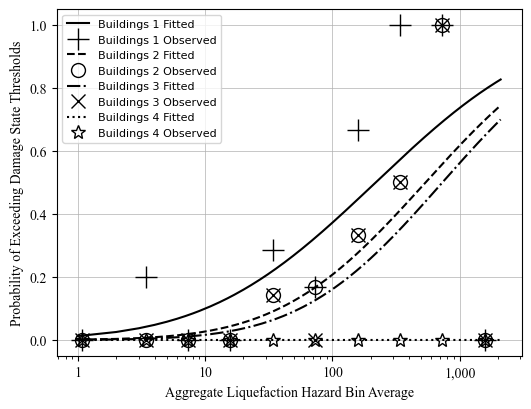

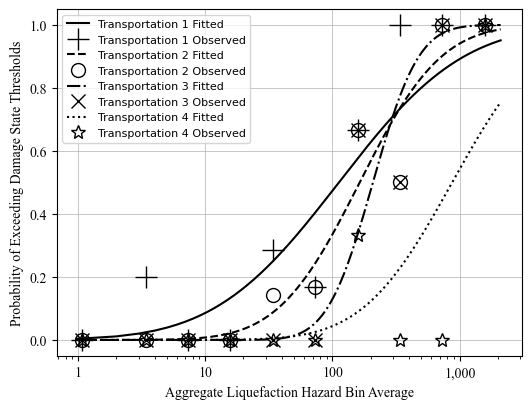

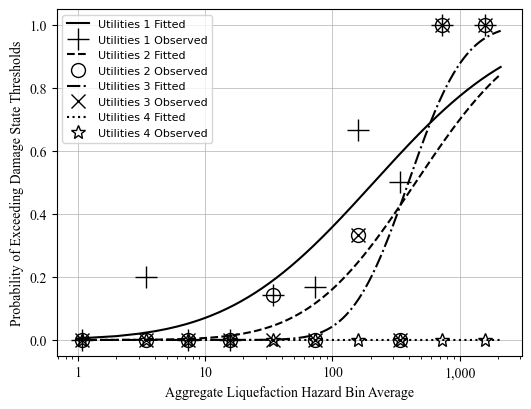

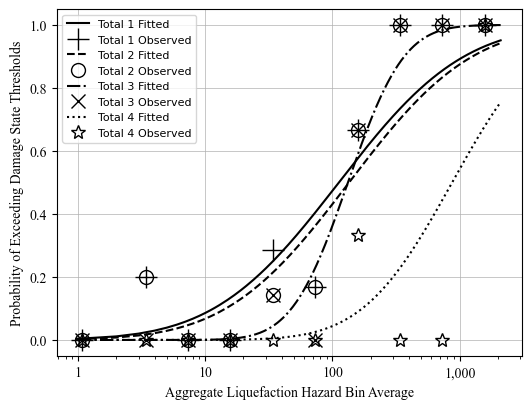

In [15]:
g_2('Buildings')
g_2('Transportation')
g_2('Utilities')
g_2('Total')

## Repeat the above work & including 5th Damage State

In [22]:
# Create bins of damage level labels and sort events into Bins
damage_cut_labels = [0,1,2,3,4,5]
# Minimum bin edge must be slightly less than 0 to account for dollars damage =0
damage_cut_bins = [-0.1, 1000, 100000, 1000000, 10000000, 100000000, 1000000000]


df = pd.read_csv("gfailruns_allevents_forAlex_v2.3.csv") # Import CSV of Name, TLSE, Building level, Transportation Level, Utilities Level
df = df.dropna(subset=['Buildings_Cost']) # Drop rows where DS is No Value for Buildings (should be same rows for Transportation and Utilities)
df.drop(df[df['American?'] == 0].index, inplace=True) # Dropping non-American events

# Minimum bin edge must be slightly less than 0 to account for TLSE=0
# EDP_cut_bins = np.linspace(-100, 5200, num=54)
EDP_cut_bins = xxx4

#################################################################################
# Create bins of TLSE labels and sort events into Bins
EDP_cut_labels = np.linspace(0,len(EDP_cut_bins)-2,num=int(len(EDP_cut_bins)-1))
# Creating column for which bin the TLSE falls into
df['TLSE_Bin'] = pd.cut(df['HaggLQ'], bins=EDP_cut_bins, labels=EDP_cut_labels)


# Calculating middle value for each bin
zipped_lists = zip(EDP_cut_bins[0:len(EDP_cut_bins)-1], EDP_cut_bins[1:len(EDP_cut_bins)])
Bin_Avg = [(x + y)/2 for (x, y) in zipped_lists]

# Making dataframe in which we can view damage level data
df2 = pd.DataFrame(zip(EDP_cut_bins[0:len(EDP_cut_bins)-1], EDP_cut_bins[1:len(EDP_cut_bins)],
                            Bin_Avg[0:len(EDP_cut_bins)-1], EDP_cut_labels[0:len(EDP_cut_bins)-1]),
                            columns=['Bin_Min', 'Bin_Max','Bin_Avg','Bin_Labels']) 

# Counting number of analyses per bin
def count_(bin_type,bin_lev):
    subset_df = df[bin_type == bin_lev]
    return subset_df.TLSE_Bin.count()

y=[]
# Need to have a +1 because of the way range() counts upwards, it stops 1 short of upper limit
# For all labels, count the number of analyses in that level
for i in range(0,len(EDP_cut_labels)):
    y.append(count_(df.TLSE_Bin,i)) 
    
# Appending this column to dataframe or recreate dataframe with it included
df2['Num_Analyses']=y

df2.drop(df2[df2['Num_Analyses'] == 0].index, inplace=True) # Dropping bins with 0 events
df2 = df2.reset_index(drop=True) # resetting index to start at 0

def damagelevel(infrastructure):
    df[str(infrastructure)+'_CostBin'] = pd.cut(df[str(infrastructure)+'_Cost'], bins=damage_cut_bins, labels=damage_cut_labels)
    df.head(20)

damagelevel('Buildings')
damagelevel('Transportation')
damagelevel('Utilities')
damagelevel('Total')

# Probably going to change the below line to fit new DSs
d = [df["Buildings_Cost"].max(), df["Transportation_Cost"].max(), df["Utilities_Cost"].min()]
DS_max = len(damage_cut_labels)

# Counts the number of events over a specified damage level for each TLSE bin
def count_(bin_type, T_bin_lev, Dam_bin_lev):
    # select only rows where the TLSE bin is equal to bin i
    subset_df=df[df.TLSE_Bin == T_bin_lev]
    # select only rows where the buildings/transportation/utilities level is >= level j
    subset_df=subset_df[bin_type >= Dam_bin_lev]
    return subset_df.TLSE_Bin.count()

# Appends number exceeding DS to arrays in correct order
# For the range of all damage states, need +1 because of way range counts upwards
for j in range(0,len(damage_cut_labels)):
    # Creating empty arrays 
    y1=[]
    y2=[]
    y3=[]
    y4=[]
    
    # For each EDP Bin
    for i in range(0,len(df2)): 
        # count the number of analyses of damage state "j", for bin label in row "i" of df2
        # Uses the function "count_" created a few blocks up
        y1.append(count_(df.Buildings_CostBin, df2.iloc[i,3], j))        
        y2.append(count_(df.Transportation_CostBin, df2.iloc[i,3], j))
        y3.append(count_(df.Utilities_CostBin, df2.iloc[i,3], j))
        y4.append(count_(df.Total_CostBin, df2.iloc[i,3],j))
    df3 = pd.DataFrame(y1)
    # CDS instead of DS represents "Cost Damage States"
    # "Observed" refers to proportion of total analyses for that bin reaching specified CDS
    df2['Buildings_CDS_'+str(j)] = df3
    df2['Buildings_CDS_'+str(j)+'_Observed'] = df2['Buildings_CDS_'+str(j)]/df2['Num_Analyses']
    df3 = pd.DataFrame(y2)
    df2['Transportation_CDS_'+str(j)] = df3
    df2['Transportation_CDS_'+str(j)+'_Observed'] = df2['Transportation_CDS_'+str(j)]/df2['Num_Analyses']
    df3 = pd.DataFrame(y3)
    df2['Utilities_CDS_'+str(j)] = df3
    df2['Utilities_CDS_'+str(j)+'_Observed'] = df2['Utilities_CDS_'+str(j)]/df2['Num_Analyses']
    df3 = pd.DataFrame(y4)
    df2['Total_CDS_'+str(j)] = df3
    df2['Total_CDS_'+str(j)+'_Observed'] = df2['Total_CDS_'+str(j)]/df2['Num_Analyses']
    
df5 = df2.drop(['Buildings_CDS_0', 'Buildings_CDS_0_Observed', 'Transportation_CDS_0', 
                'Transportation_CDS_0_Observed', 'Utilities_CDS_0', 
                'Utilities_CDS_0_Observed'], axis=1) # Drop these columns

/Users/Alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [23]:
# df4 represents creating x values of fragility curve itself
# Must start at 1 instead of 0 because log(0) does not exist
xx = np.linspace(1, max(df['HaggLQ']), num=int(max(df['HaggLQ'])))
df4 = pd.DataFrame(xx,columns=['Aggregate Liquefaction Hazard'])
aa = df4.iloc[:,0]

def g_2(category):
    
    # Plotting fragility functions with observed points
    mpl.style.use('default')
    fig, ax = plt.subplots(figsize=(6, 4.5))
    csfont = {'fontname':'Times New Roman'}
    ax.set_xscale('log')
    
    for DS in range(1,len(damage_cut_labels)):
      # This is where we need to have definition of loop start    
        a1 = df2.iloc[:,4] # Num events in each bin
        a2 = df2[str(category)+'_CDS_'+str(DS)] # Num exceedances (Building level 1) in each bin
        a3 = df2.iloc[:,2] # Avg bin TLSE values

        a1 = a1.values.tolist()
        a2 = a2.values.tolist()
        a3 = a3.values.tolist()
        
        # Define function to be maximum using Automation
        def f(params):
            theta, beta = params
            bounds = ((0,None),(0,None))
            # CDF finds the probability of exceeding damage state
            # PMF is the likelihood of achieving the CDF value given the number of events in each bin and exceedances of damage state
            # Get product of likelihoods
            # Use -1 to get maximum insted of minimum
            c = []
            d = []
            for i in range(0,len(df2)):
                c.append(stats.binom.pmf(a2[i], a1[i], stats.norm.cdf(math.log(a3[i]), loc=math.log(theta),scale=beta)))  
            return -1*np.product([c])

        # Minimize the defined function using starting theta and beta
        # Some reason this is coming out with parameters near the input only instead of actual results
        res = minimize(f,[100,10],method='Nelder-Mead',options={'maxiter': 10000})

        if res.success:
            fitted_params = res.x
            print(fitted_params)
        else:
            raise ValueError(res.message)

        # Creating fitted fragility points from fitted parameters for the curve
        yy=[]
        for i in range(0,len(df4)):
            yy.append(stats.norm.cdf(math.log(aa[i]),loc=math.log(fitted_params[0]),scale=fitted_params[1]))
        ######################################################################  
        df4['Fitted_Values_CDS_'+str(DS)]=yy # Adding column to dataframe
        # THE ABOVE ALSO CONTAINS RELATIONSHIPS 
    ######################################################################   
        
        #ax.plot('Aggregate Liquefaction Hazard', 'Fitted_Values_CDS_'+str(DS), 'k-', label=str(category)+' '+str(DS)+' Fitted',data=df4)
        #ax.plot('Bin_Avg', str(category)+'_CDS_'+str(DS)+'_Observed','k+', markersize=16,
                #label=str(category)+' '+str(DS)+' Observed',data=df5)

        #print(df4['Fitted_Values_CDS_1'])
    ax.plot('Aggregate Liquefaction Hazard', 'Fitted_Values_CDS_1', 'k:', label=str(category)+' 1'+' Fitted',data=df4)
    ax.plot('Bin_Avg', str(category)+'_CDS_1'+'_Observed','kd', markersize=10, markerfacecolor='none',
            label=str(category)+' 1'+' Observed',data=df5)

    ax.plot('Aggregate Liquefaction Hazard', 'Fitted_Values_CDS_2', 'k-', label=str(category)+' 2'+' Fitted',data=df4)
    ax.plot('Bin_Avg', str(category)+'_CDS_2'+'_Observed','k+', mfc='none', markersize=16,
           label=str(category)+' 2'+' Observed',data=df5) # DS_1 observed

    ax.plot('Aggregate Liquefaction Hazard', 'Fitted_Values_CDS_3', 'k--', label=str(category)+' 3'+' Fitted',data=df4)
    ax.plot('Bin_Avg', str(category)+'_CDS_3'+'_Observed','ko', markersize=10, markerfacecolor='none',
            label=str(category)+' 3'+' Observed',data=df5)

    ax.plot('Aggregate Liquefaction Hazard', 'Fitted_Values_CDS_4', 'k-.', label=str(category)+' 4'+' Fitted',data=df4)
    ax.plot('Bin_Avg', str(category)+'_CDS_4'+'_Observed','kx', mfc='none', markersize=10,
           label=str(category)+' 4'+' Observed',data=df5) # DS_1 observed

    ax.plot('Aggregate Liquefaction Hazard', 'Fitted_Values_CDS_5', 'k:', label=str(category)+' 5'+' Fitted',data=df4)
    ax.plot('Bin_Avg', str(category)+'_CDS_5'+'_Observed','k*', mfc='none', markersize=10,
           label=str(category)+' 5'+' Observed',data=df5) # DS_1 observed
    
    plt.xlabel('Aggregate Liquefaction Hazard Bin Average', fontsize=10,**csfont)
    plt.ylabel('Probability of Exceeding Damage State Thresholds', fontsize=10,**csfont)
    plt.legend(loc='upper left', fontsize='8')

    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.xaxis.set_major_formatter(tick)
    plt.xticks([1,10,100,1000],**csfont)
        # For ticks, need max to be one unit higher than the value I actually want
    plt.ylim(-0.05, 1.05)
    plt.yticks(np.arange(0, 1.2, 0.2),**csfont)
    plt.grid(linestyle='-', linewidth='0.5')
    #plt.savefig('HtotCostFxns_5Levs_'+str(category)+'.png',format="PNG",dpi=500,bbox_inches="tight")

[160.74381237   2.66205833]
[507.75259631   2.78650943]
[539.57562814   2.06596692]
[732.20460355   2.01021167]
[3.00826401e+03 2.00805664e-02]
[93.62730869  1.77842395]
[211.1810342    2.06770986]
[163.78072179   1.15715913]
[208.18474168   0.64952686]
[873.43491378   1.27015455]
[170.81453      2.09694253]
[479.59489479   2.41402034]
[451.07989391   1.52324452]
[395.922309     0.80055048]
[3.00826401e+03 2.00805664e-02]
[85.89838833  2.00929601]
[135.25886836   1.74119909]
[135.25886836   1.74119909]
[132.3806011    0.79625861]
[873.43491378   1.27015455]


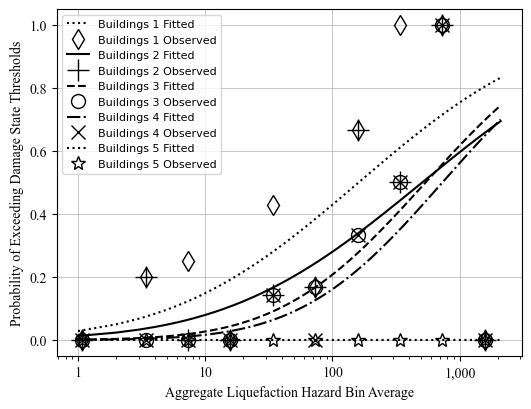

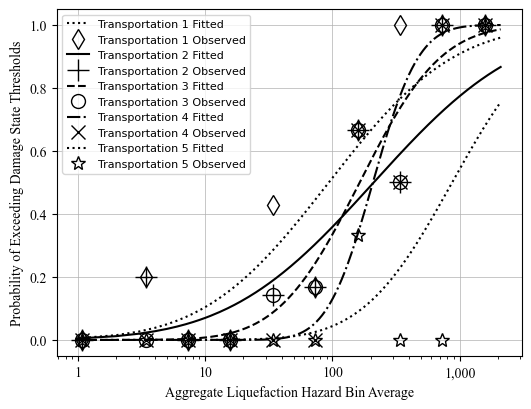

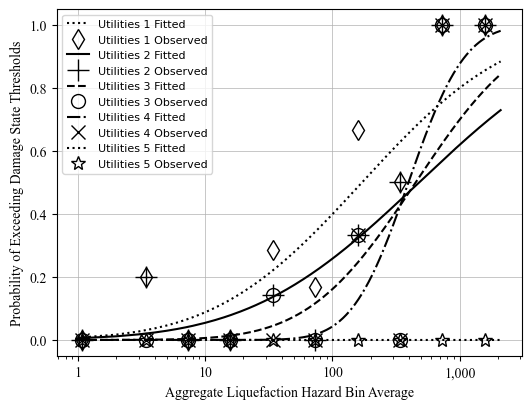

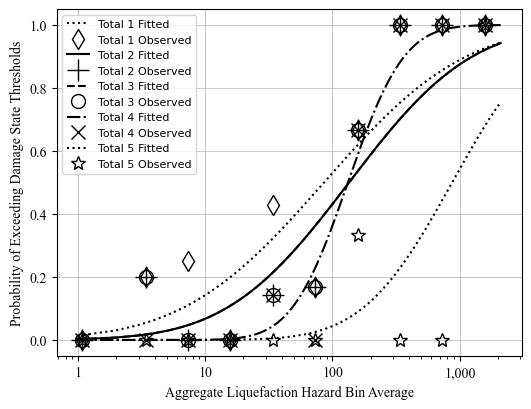

In [24]:
g_2('Buildings')
g_2('Transportation')
g_2('Utilities')
g_2('Total')